# Exploring Amazon Images for Kaggle Competition

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plot
import seaborn as sns
import keras as k
import cv2
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
import time
sns.set_style("white")
%matplotlib inline
from sklearn.model_selection import KFold

pal = sns.color_palette()

df_train = pd.read_csv('train_v2.csv')
df_train.head()

Using TensorFlow backend.


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


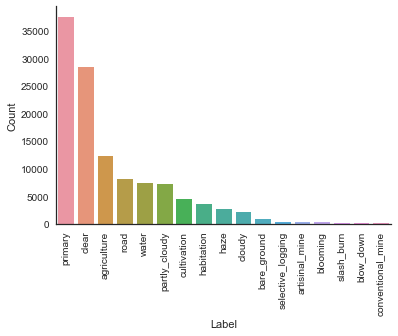

In [2]:
labels = df_train['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1
df_counts = pd.DataFrame(list(counts.items()),columns=["Label","Count"])
#df_counts.columns
df_counts = df_counts.sort_values("Count",ascending=False)
g = sns.barplot(x="Label",y="Count",data=df_counts)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set(ylabel="Count")
sns.despine()


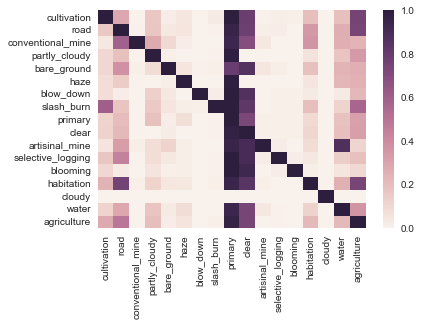

In [ ]:
# Co-occurence Matrix
com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

sns.heatmap(com,xticklabels=list(counts.keys()),yticklabels=list(counts.keys()))
#data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
#layout=go.Layout(height=800, width=800, title='Co-occurence matrix of training labels')
#fig=dict(data=data, layout=layout)
#py.iplot(data, filename='train-com')

In [ ]:
## Lets try a CNN using keras and the tensorflow backend!
x_train = []
x_test = []
y_train = []

df_train = pd.read_csv('train_v2.csv')
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

df_test = pd.read_csv('sample_submission_v2.csv')

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (64, 64)))
    y_train.append(targets)

for f, tags in tqdm(df_test.values, miniters=1000):
    img = cv2.imread('test-jpg/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (64, 64)))
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)/255.
x_test  = np.array(x_test, np.float32)/255.


100%|████████████████████████████████████| 40669/40669 [21:15<00:00, 31.87it/s]


In [ ]:
print(x_train.shape)
print(y_train.shape)



In [ ]:
from sklearn.metrics import fbeta_score

nfolds = 5

num_fold = 0
sum_score = 0

yfull_test = []
yfull_train =[]

kf = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for train_index, test_index in kf.split(x_train):
        start_time_model_fitting = time.time()
        
        X_train = x_train[train_index]
        Y_train = y_train[train_index]
        X_valid = x_train[test_index]
        Y_valid = y_train[test_index]

        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(X_train), len(Y_train))
        print('Split valid: ', len(X_valid), len(Y_valid))
        
        kfold_weights_path = os.path.join('', 'weights_kfold_' + str(num_fold) + '.h5')
        
        model = Sequential()
        model.add(BatchNormalization(input_shape=(64, 64,3)))
        model.add(Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=(3, 3),padding='same', activation='relu'))
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(17, activation='sigmoid'))

        epochs_arr = [20, 5, 5]
        learn_rates = [0.001, 0.0001, 0.00001]

        for learn_rate, epochs in zip(learn_rates, epochs_arr):
            opt  = optimizers.Adam(lr=learn_rate)
            model.compile(loss='binary_crossentropy',
                          optimizer=opt,
                          metrics=['accuracy'])
            callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0),
            ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0)]

            model.fit(x = X_train, y= Y_train, validation_data=(X_valid, Y_valid),
                  batch_size=128,verbose=2, epochs=epochs,callbacks=callbacks,shuffle=True)
        
        if os.path.isfile(kfold_weights_path):
            model.load_weights(kfold_weights_path)
        
        p_valid = model.predict(X_valid, batch_size = 128, verbose=2)
        print(fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

        p_train = model.predict(x_train, batch_size =128, verbose=2)
        yfull_train.append(p_train)
        
        p_test = model.predict(x_test, batch_size = 128, verbose=2)
        yfull_test.append(p_test)



790s - loss: 0.3975 - acc: 0.8387 - val_loss: 0.2393 - val_acc: 0.9136
Epoch 2/20
698s - loss: 0.2468 - acc: 0.9109 - val_loss: 0.2285 - val_acc: 0.9154
Epoch 3/20
708s - loss: 0.2346 - acc: 0.9141 - val_loss: 0.2192 - val_acc: 0.9192
Epoch 4/20
708s - loss: 0.2259 - acc: 0.9177 - val_loss: 0.2155 - val_acc: 0.9215
Epoch 5/20
702s - loss: 0.2212 - acc: 0.9189 - val_loss: 0.2152 - val_acc: 0.9208
Epoch 6/20
698s - loss: 0.2156 - acc: 0.9207 - val_loss: 0.2126 - val_acc: 0.9216
Epoch 7/20
697s - loss: 0.2126 - acc: 0.9219 - val_loss: 0.2121 - val_acc: 0.9220
Epoch 8/20
698s - loss: 0.2115 - acc: 0.9223 - val_loss: 0.2154 - val_acc: 0.9204
Epoch 9/20
699s - loss: 0.2136 - acc: 0.9211 - val_loss: 0.2101 - val_acc: 0.9226
Epoch 10/20
721s - loss: 0.2090 - acc: 0.9224 - val_loss: 0.2106 - val_acc: 0.9218
Epoch 11/20
699s - loss: 0.2051 - acc: 0.9231 - val_loss: 0.2108 - val_acc: 0.9197
Epoch 12/20
698s - loss: 0.1914 - acc: 0.9257 - val_loss: 0.1970 - val_acc: 0.9226
Epoch 13/20
698s - loss:

Train on 32383 samples, validate on 8096 samples
Epoch 1/5
719s - loss: 0.2057 - acc: 0.9219 - val_loss: 0.2042 - val_acc: 0.9210
Epoch 2/5
707s - loss: 0.2014 - acc: 0.9222 - val_loss: 0.2012 - val_acc: 0.9204
Epoch 3/5
707s - loss: 0.1982 - acc: 0.9228 - val_loss: 0.1938 - val_acc: 0.9223
Epoch 4/5
707s - loss: 0.1965 - acc: 0.9236 - val_loss: 0.1883 - val_acc: 0.9240
Epoch 5/5
708s - loss: 0.1945 - acc: 0.9244 - val_loss: 0.1904 - val_acc: 0.9230
Train on 32383 samples, validate on 8096 samples
Epoch 1/5
715s - loss: 0.1923 - acc: 0.9257 - val_loss: 0.1854 - val_acc: 0.9269
Epoch 2/5
706s - loss: 0.1918 - acc: 0.9256 - val_loss: 0.1850 - val_acc: 0.9273
Epoch 3/5
707s - loss: 0.1912 - acc: 0.9259 - val_loss: 0.1846 - val_acc: 0.9276
Epoch 4/5
706s - loss: 0.1912 - acc: 0.9259 - val_loss: 0.1848 - val_acc: 0.9280
Epoch 5/5
706s - loss: 0.1911 - acc: 0.9258 - val_loss: 0.1843 - val_acc: 0.9282
0.812736434713
Start KFold number 5 from 5
Split train:  32384 32384
Split valid:  8095 8095

In [ ]:

result = np.array(yfull_test[0])
for i in range(1, nfolds):
    result += np.array(yfull_test[i])
result /= nfolds
result = pd.DataFrame(result, columns = labels)
result

from tqdm import tqdm
thres = [0.07, 0.17, 0.2, 0.04, 0.23, 0.33, 0.24, 0.22, 0.1, 0.19, 0.23, 0.24, 0.12, 0.14, 0.25, 0.26, 0.16]
preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
    
df_test['tags'] = preds
df_test.to_csv('submission_CNN_keras.csv', index=False)

  0%|                                                | 0/40669 [00:00<?, ?it/s]C:\Users\jminucci\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  del sys.path[0]
100%|███████████████████████████████████| 40669/40669 [01:22<00:00, 491.40it/s]
